# Инициализация модели

In [1]:
from torch import nn


class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(
            nn.Linear(100, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.05),  # 20% probability
            nn.ReLU(),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        # return self.core(x.unsqueeze(1))
        return self.core(x)

# Загрузка весов модели

In [3]:
import torch

log_path = 'best_ckp/'
ckpt_path = f"{log_path}model-v64.ckpt"
checkpoint = torch.load(ckpt_path)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict = {}
for key in checkpoint["state_dict"].keys():
    key_new = key.lstrip("model.")
    state_dict[key_new] = checkpoint["state_dict"][key]

model = SimpleModel()

model.load_state_dict(state_dict)

model.eval()

/tmp/ipykernel_8337/2028999460.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Checkpoint has been loaded from best_ckp/model-v64.ckpt
Best model has been saved on the 493 epoch


SimpleModel(
  (core): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=256, bias=True)
    (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.05, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=6, bias=True)
  )
)

# Загрузка тестовых данных

In [6]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class MyDataset(Dataset):
    def __init__(self, x, y, mu=None, sigma=None):
        super().__init__()
        self.x = x
        self.y = y
        self.mu = mu
        self.sigma = sigma

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        item_x = self.x[idx]
        item_y = self.y[idx]
        if self.mu is not None:
            item_x = item_x + torch.randn(len(item_x)) * self.sigma + self.mu
        return item_x, item_y


def import_data(directory_path, file_path, mu, sigma):
    df = pd.read_table(os.path.join(directory_path, file_path), header=None)
    df_numpy = np.float32(df.values)
    tensor_x = torch.from_numpy(df_numpy[:, 7:])
    tensor_y = torch.from_numpy(df_numpy[:, 0:6])
    ds = MyDataset(tensor_x, tensor_y, mu=mu, sigma=sigma)
    return ds, tensor_x, tensor_y

ds_test, tensor_x_test, tensor_y_test = import_data(
    directory_path="",
    file_path="D2024_11_17 T10_40 samples=2000 test.txt",
    mu=None,
    sigma=None,
)

# Сравнение реальных и восстановленных параметров

## Для одного объекта

In [10]:
model.eval()
sample_num = 436
print(tensor_y_test[None, sample_num, :])
print(model(tensor_x_test[None, sample_num, :]))

tensor([[0.5370, 0.3559, 0.3006, 0.0939, 0.8486, 0.4846]])
tensor([[0.5412, 0.3654, 0.2847, 0.0997, 0.8451, 0.4664]],
       grad_fn=<AddmmBackward0>)


## Для множества объектов

### Визуальное сравнение значений

  0%|          | 0/2000 [00:00<?, ?it/s]

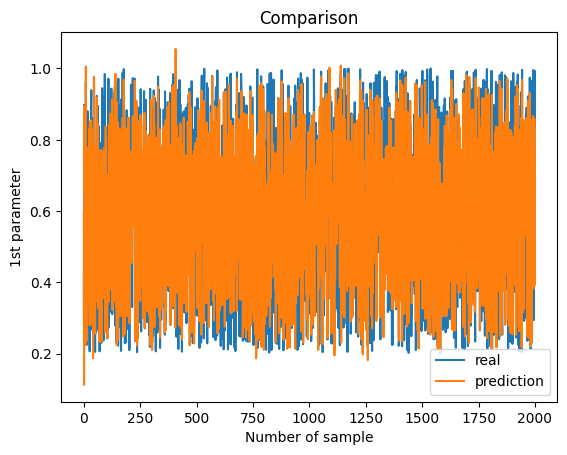

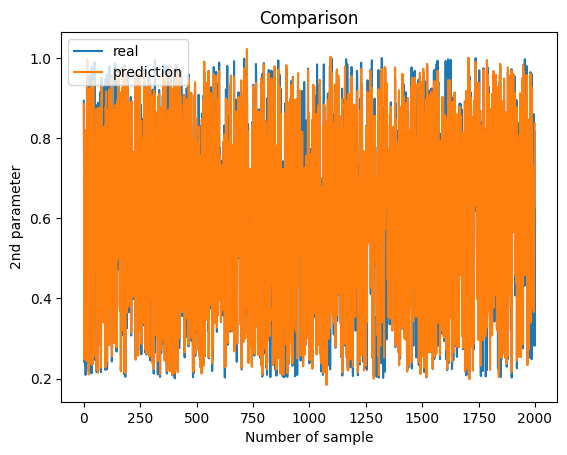

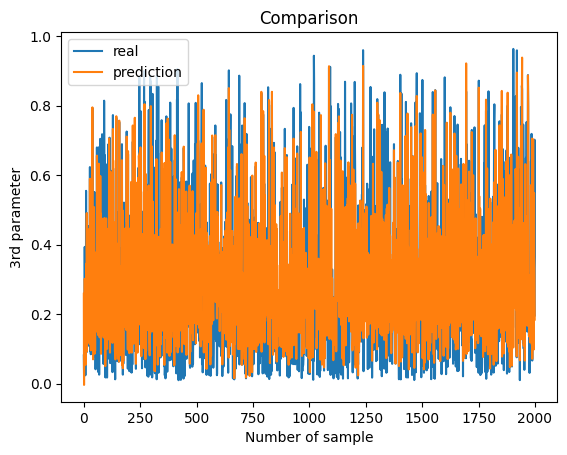

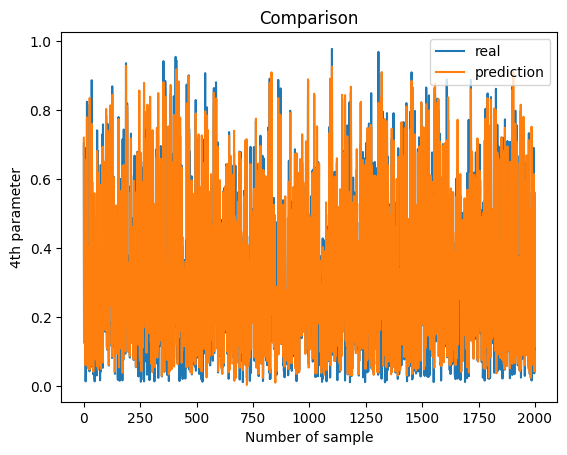

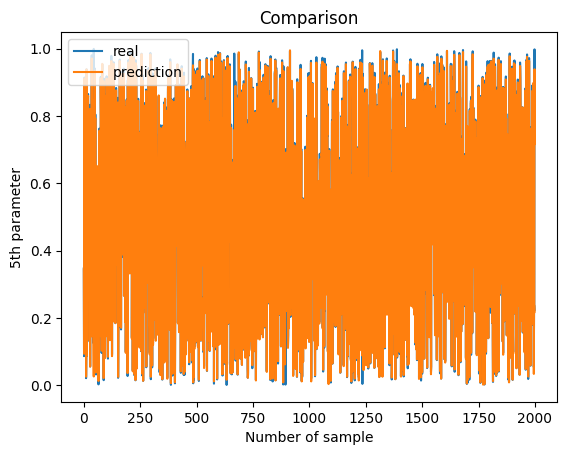

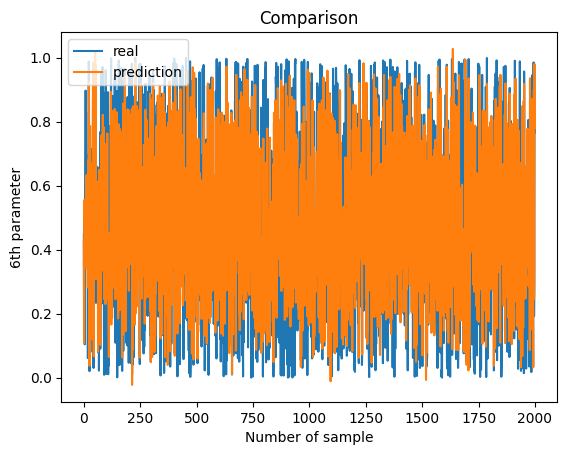

In [11]:
model.eval()
num_samples = tensor_x_test.shape[0]
pred1 = np.zeros(num_samples)
pred2 = np.zeros(num_samples)
pred3 = np.zeros(num_samples)
pred4 = np.zeros(num_samples)
pred5 = np.zeros(num_samples)
pred6 = np.zeros(num_samples)
for i in tqdm(range(num_samples)):
    pred = model(tensor_x_test[None, i, :])
    # breakpoint()
    pred1[i] = pred[0, 0]
    pred2[i] = pred[0, 1]
    pred3[i] = pred[0, 2]
    pred4[i] = pred[0, 3]
    pred5[i] = pred[0, 4]
    pred6[i] = pred[0,5]

plt.plot(range(num_samples), tensor_y_test[:, 0], label="real")
plt.plot(range(num_samples), pred1, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("1st parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
plt.show()

plt.plot(range(num_samples), tensor_y_test[:, 1], label="real")
plt.plot(range(num_samples), pred2, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("2nd parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
plt.show()

plt.plot(range(num_samples), tensor_y_test[:, 2], label="real")
plt.plot(range(num_samples), pred3, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("3rd parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
# xlim((0,100))
plt.show()

plt.plot(range(num_samples), tensor_y_test[:, 3], label="real")
plt.plot(range(num_samples), pred4, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("4th parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
# xlim((0,100))
plt.show()

plt.plot(range(num_samples), tensor_y_test[:, 4], label="real")
plt.plot(range(num_samples), pred5, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("5th parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
# xlim((0,100))
plt.show()

plt.plot(range(num_samples), tensor_y_test[:, 5], label="real")
plt.plot(range(num_samples), pred6, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("6th parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
# xlim((0,100))
plt.show()

### Построение гистограмм MAE

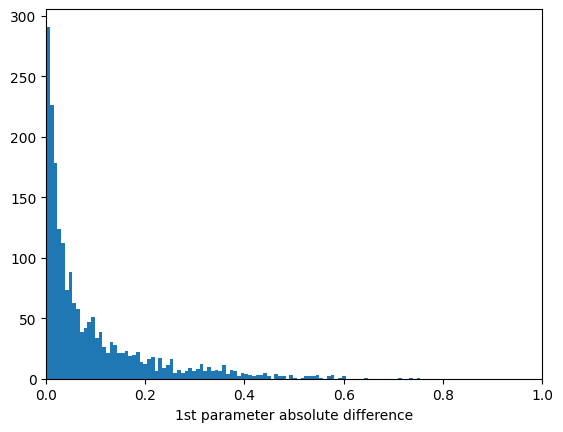

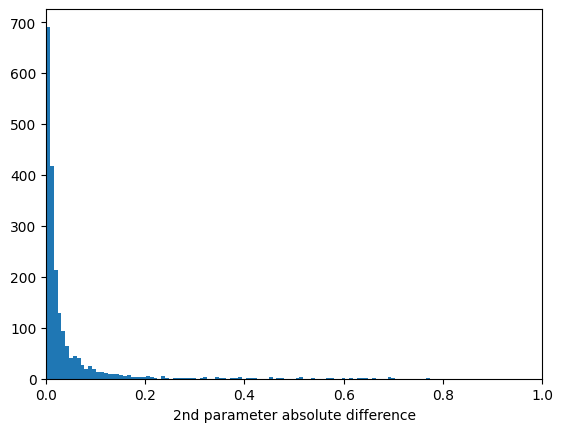

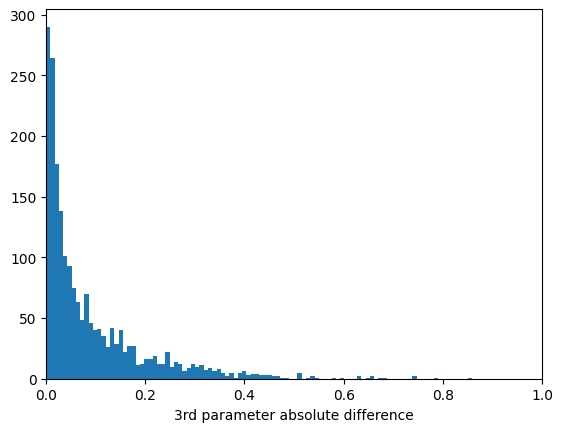

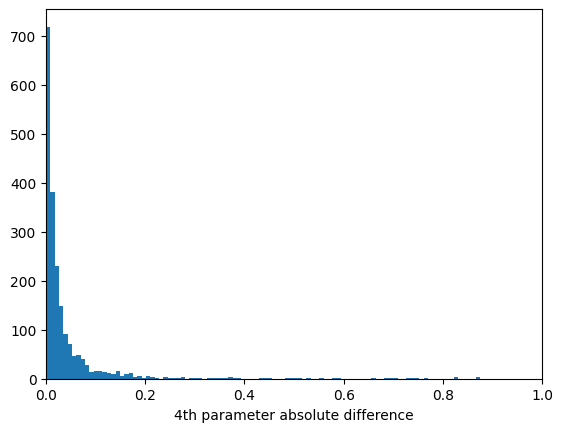

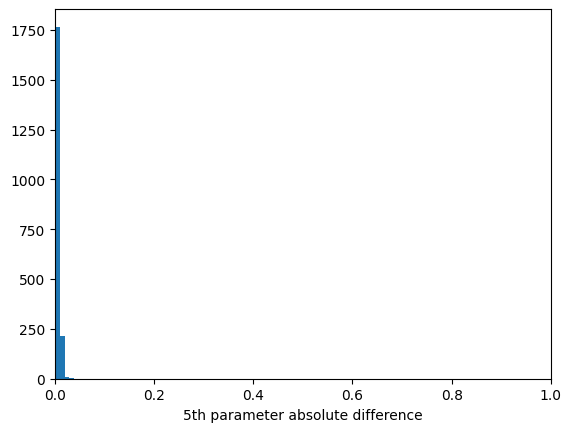

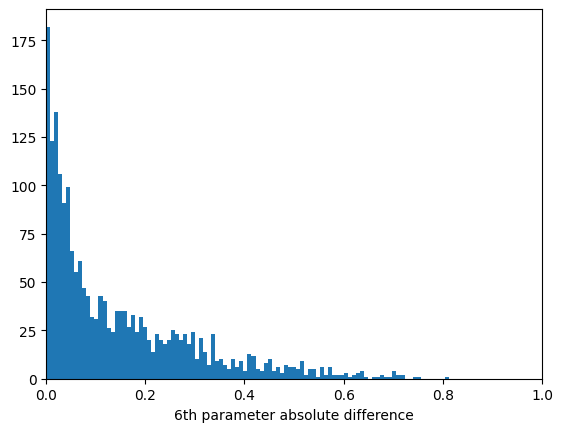

In [12]:
dy1 = abs(tensor_y_test[:,0] - pred1)
plt.hist(bins=100, x=dy1)
plt.xlabel("1st parameter absolute difference")
plt.xlim((0,1))
plt.show()

dy2 = abs(tensor_y_test[:,1] - pred2)
plt.hist(bins=100, x=dy2)
plt.xlabel("2nd parameter absolute difference")
plt.xlim((0,1))
plt.show()

dy3 = abs(tensor_y_test[:,2] - pred3)
plt.hist(bins=100, x=dy3)
plt.xlabel("3rd parameter absolute difference")
plt.xlim((0,1))
plt.show()

dy4 = abs(tensor_y_test[:,3] - pred4)
plt.hist(bins=100, x=dy4)
plt.xlabel("4th parameter absolute difference")
plt.xlim((0,1))
plt.show()

dy5 = abs(tensor_y_test[:,4] - pred5)
plt.hist(bins=100,x=dy5)
plt.xlabel("5th parameter absolute difference")
plt.xlim((0,1))
plt.show()

dy6 = abs(tensor_y_test[:,5] - pred6)
plt.hist(bins=100,x=dy6)
plt.xlabel("6th parameter absolute difference")
plt.xlim((0,1))
plt.show()